In this notebook, an artificial dataset has been created with both upward trend and seasonality. To make the dataset more realistic, some noises have also been added. Then we'll try to forecast it. 

In [2]:
# Not necessary if the right version is installed
#!pip install tf-nightly-2.0-preview


In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.1.0


Time series dataset generation for 4 years, addin noises, and splitting into training and validation set (1000 and 460 days.)

In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

Function for windowing (rearranging) the dataset in order to make and time series. 

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

Function for model forecasting

In [6]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

preparing the training set with a reasonable window size and batch size

In [10]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

Model defination with convolutional layer, bidirectional LSTM layers and dense layer

In [11]:

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])


Running the model with proper set of hyperparameters, Finding the proper learning rate...

In [12]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 11s 1s/step - loss: 73.2700 - mae: 73.6896
Epoch 2/100
8/8 [==============================] - 2s 200ms/step - loss: 72.3807 - mae: 72.9788
Epoch 3/100
8/8 [==============================] - 1s 156ms/step - loss: 71.2596 - mae: 71.8377
Epoch 4/100
8/8 [==============================] - 1s 146ms/step - loss: 69.8434 - mae: 70.4184
Epoch 5/100
8/8 [==============================] - 1s 187ms/step - loss: 68.2533 - mae: 68.7583
Epoch 6/100
8/8 [==============================] - 2s 196ms/step - loss: 66.3086 - mae: 66.8782
Epoch 7/100
8/8 [==============================] - 1s 167ms/step - loss: 64.2200 - mae: 64.7353
Epoch 8/100
8/8 [==============================] - 1s 151ms/step - loss: 61.7602 - mae: 62.3713
Epoch 9/100
8/8 [==============================] - 1s 152ms/step - loss: 59.1640 - mae: 59.7458
Epoch 10/100
8/8 [==============================] - 1s 168ms/step - loss: 56.3343 - mae: 56.8317
Epoch 11/100
8/8 [=======================

Visualize the error and finding the right learning rate ($10^{-5}$ approximately)

[1e-08, 0.0001, 0, 30]

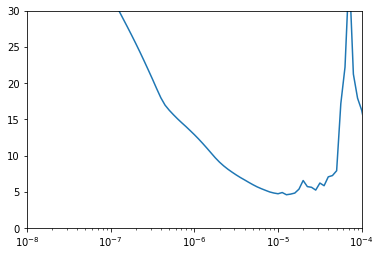

In [13]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

Re-running the model with right learning rate and modified convolutional layer

In [25]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 4s 131ms/step - loss: 21.5797 - mae: 22.331121.5713 - mae: 22.33
Epoch 2/100
31/31 [==============================] - 1s 37ms/step - loss: 8.2290 - mae: 8.7146
Epoch 3/100
31/31 [==============================] - 1s 33ms/step - loss: 6.6407 - mae: 7.1331
Epoch 4/100
31/31 [==============================] - 1s 35ms/step - loss: 6.1320 - mae: 6.6106
Epoch 5/100
31/31 [==============================] - 1s 35ms/step - loss: 5.8183 - mae: 6.3067
Epoch 6/100
31/31 [==============================] - 1s 34ms/step - loss: 5.5784 - mae: 6.0627
Epoch 7/100
31/31 [==============================] - 1s 36ms/step - loss: 5.4629 - mae: 5.9432
Epoch 8/100
31/31 [==============================] - 1s 39ms/step - loss: 5.3205 - mae: 5.7958
Epoch 9/100
31/31 [==============================] - 1s 38ms/step - loss: 5.2130 - mae: 5.7055
Epoch 10/100
31/31 [==============================] - 1s 34ms/step - loss: 5.2043 - mae: 5.6914
Epoch 11/100
31/31 [======

Model prediction and comparing

In [26]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

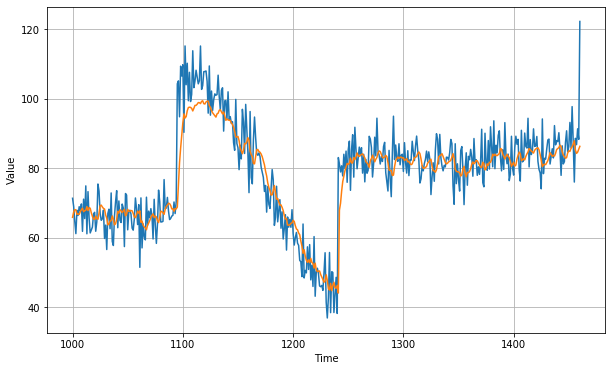

In [27]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [28]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

5.004377

Visualizing MAE and loss

<Figure size 432x288 with 0 Axes>

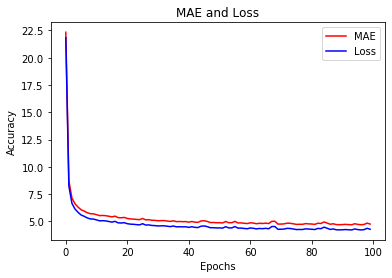

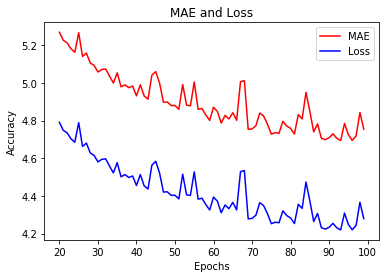

<Figure size 432x288 with 0 Axes>

In [29]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[20:]
mae_zoom = mae[20:]
loss_zoom = loss[20:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

## Try with DNN

In [34]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  dataset = tf.data.Dataset.from_tensor_slices(series)
  dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
  dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
  dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
  dataset = dataset.batch(batch_size).prefetch(1)
  return dataset

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)



<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float32, tf.float32)>


In [35]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"), 
    tf.keras.layers.Dense(10, activation="relu"), 
    tf.keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 1s 22ms/step - loss: 121.8733
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 94.7671
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 86.0413
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 79.9234
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 77.2179
Epoch 6/100
31/31 [==============================] - 0s 10ms/step - loss: 73.2479
Epoch 7/100
31/31 [==============================] - 0s 10ms/step - loss: 71.7009
Epoch 8/100
31/31 [==============================] - 0s 8ms/step - loss: 69.7999
Epoch 9/100
31/31 [==============================] - 0s 7ms/step - loss: 68.0669
Epoch 10/100
31/31 [==============================] - 0s 8ms/step - loss: 65.9647
Epoch 11/100
31/31 [==============================] - 0s 8ms/step - loss: 64.4412
Epoch 12/100
31/31 [==============================] - 0s 8ms/step - loss: 63.1277
Epoch 13/100
31/31 [=

31/31 [==============================] - 0s 8ms/step - loss: 46.4385


[ 63.51229   66.70206   68.56336   68.64332   59.412083  64.881386
  66.72695   66.302536  67.15385   67.08288   64.40304   65.12412
  65.94476   70.06018   64.9204    68.04707   65.88434   64.93526
  62.250164  64.02392   61.960896  65.20143   65.78641   65.84934
  65.68458   66.969055  70.34663   66.97534   65.70968   64.565704
  63.106598  62.214878  61.376884  63.703453  64.92902   63.850895
  65.684494  64.18138   60.123997  63.929253  64.85987   72.550995
  64.75533   63.80911   65.45265   67.081955  68.727646  66.50866
  61.109093  66.390656  69.66539   67.1633    65.56826   63.1926
  67.64039   65.54908   62.447678  62.88102   64.48942   67.82911
  65.41391   69.002754  62.867104  59.572124  61.29029   63.00589
  61.972797  62.42097   61.51455   64.70829   62.963913  66.35752
  65.85508   65.6366    63.304417  66.62097   64.461266  59.730812
  63.708794  67.88038   67.67342   66.29779   62.26849   65.03188
  70.75614   67.50289   70.14942   65.640915  67.10859   69.82268
  65.5

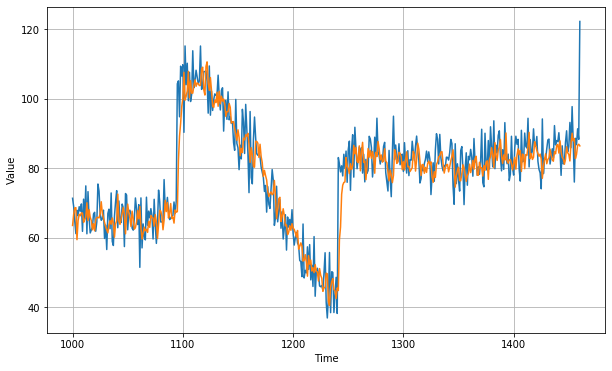

In [36]:
forecast = []

for time in range(len(series) - window_size):
  forecast.append(model.predict(series[time:time + window_size][np.newaxis]))
  
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]

print(results)
plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)